# Time Series Forecasting
Find the pattern and predict future

## Import Packages

In [3]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from arch import arch_model
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()

## Load Dataset

In [4]:
raw_data = yfinance.download (
    tickers = "^GSPC ^FTSE ^N225 ^GDAXI", 
    start = "1994-01-07", 
    end = "2019-09-01", 
    interval = "1d", 
    group_by = 'ticker', 
    auto_adjust = True, 
    treads = True)

[*********************100%***********************]  4 of 4 completed


In [6]:
df_comp = raw_data.copy()

In [7]:
df_comp.head()

^N225                                                   \
                    Open          High           Low         Close Volume   
Date                                                                        
1994-01-07  17842.980469  18131.410156  17787.480469  18124.009766    0.0   
1994-01-10  18186.519531  18567.060547  18186.519531  18443.439453    0.0   
1994-01-11  18481.849609  18671.669922  18373.039062  18485.250000    0.0   
1994-01-12  18447.339844  18807.080078  18301.929688  18793.880859    0.0   
1994-01-13  18770.380859  18823.380859  18548.750000  18577.259766    0.0   

                  ^FTSE                                                \
                   Open         High          Low        Close Volume   
Date                                                                    
1994-01-07  3401.399902  3446.800049  3398.699951  3446.000000    0.0   
1994-01-10  3465.699951  3468.100098  3430.000000  3440.600098    0.0   
1994-01-11  3442.500000  3442.500000  3413.500000  3413.800049    0.0   
1994-01-12  3394.800049  3402.399902  3372.000000  3372.000000    0.0   
1994-01-13  3380.699951  3383.300049  3356.899902  3360.000000    0.0   

                 ^GSPC                                                   \
                  Open        High         Low       Close       Volume   
Date                                                                      
1994-01-07  467.089996  470.260010  467.029999  469.899994  324920000.0   
1994-01-10  469.899994  475.269989  469.549988  475.269989  319490000.0   
1994-01-11  475.269989  475.279999  473.269989  474.130005  305490000.0   
1994-01-12  474.130005  475.059998  472.140015  474.170013  310690000.0   
1994-01-13  474.170013  474.170013  471.799988  472.470001  277970000.0   

                 ^GDAXI                                                
                   Open         High          Low        Close Volume  
Date                                                                   
1994-01-07  2218.959961  2227.639893  2201.820068  2224.949951    0.0  
1994-01-10  2231.840088  2238.010010  2222.000000  2225.000000    0.0  
1994-01-11  2225.429932  2235.610107  2225.179932  2228.100098    0.0  
1994-01-12  2227.120117  2227.790039  2182.060059  2182.060059    0.0  
1994-01-13  2171.500000  2183.709961  2134.100098  2142.370117    0.0

In [8]:
df_comp['spx'] = df_comp['^GSPC'].Close[:]
df_comp['dax'] = df_comp['^GDAXI'].Close[:]
df_comp['ftse'] = df_comp['^FTSE'].Close[:]
df_comp['nikkei'] = df_comp['^N225'].Close[:]

df_comp = df_comp.iloc[1:]
del df_comp['^N225']
del df_comp['^GSPC']
del df_comp['^GDAXI']
del df_comp['^FTSE']

df_comp.head()

,spx,dax,ftse,nikkei
,,,,
Date,,,,
1994-01-10,475.269989,2225.000000,3440.600098,18443.439453
1994-01-11,474.130005,2228.100098,3413.800049,18485.250000
1994-01-12,474.170013,2182.060059,3372.000000,18793.880859
1994-01-13,472.470001,2142.370117,3360.000000,18577.259766
1994-01-14,474.910004,2151.050049,3400.600098,18973.699219


In [10]:
df_comp.index

DatetimeIndex(['1994-01-10', '1994-01-11', '1994-01-12', '1994-01-13',
               '1994-01-14', '1994-01-17', '1994-01-18', '1994-01-19',
               '1994-01-20', '1994-01-21',
               ...
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-26', '2019-08-27', '2019-08-28',
               '2019-08-29', '2019-08-30'],
              dtype='datetime64[ns]', name='Date', length=6672, freq=None)

In [11]:
df_comp=df_comp.asfreq('b')
df_comp=df_comp.fillna(method='ffill')
df_comp.index

DatetimeIndex(['1994-01-10', '1994-01-11', '1994-01-12', '1994-01-13',
               '1994-01-14', '1994-01-17', '1994-01-18', '1994-01-19',
               '1994-01-20', '1994-01-21',
               ...
               '2019-08-19', '2019-08-20', '2019-08-21', '2019-08-22',
               '2019-08-23', '2019-08-26', '2019-08-27', '2019-08-28',
               '2019-08-29', '2019-08-30'],
              dtype='datetime64[ns]', name='Date', length=6690, freq='B')

## Create returns

In [12]:
df_comp['ret_spx'] = df_comp.spx.pct_change(1).mul(100)
df_comp['ret_ftse'] = df_comp.ftse.pct_change(1).mul(100)
df_comp['ret_dax'] = df_comp.dax.pct_change(1).mul(100)
df_comp['ret_nikkei'] = df_comp.nikkei.pct_change(1).mul(100)

In [13]:
# Normalization
df_comp['norm_ret_spx'] = df_comp.ret_spx.div(df_comp.ret_spx[1])*100
df_comp['norm_ret_ftse'] = df_comp.ret_ftse.div(df_comp.ret_ftse[1])*100
df_comp['norm_ret_dax'] = df_comp.ret_dax.div(df_comp.ret_dax[1])*100
df_comp['norm_ret_nikkei'] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1])*100

In [14]:
df_comp.head()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
1994-01-10,475.269989,2225.000000,3440.600098,18443.439453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-11,474.130005,2228.100098,3413.800049,18485.250000,-0.239860,-0.778935,0.139330,0.226696,100.000000,100.000000,100.000000,100.000000
1994-01-12,474.170013,2182.060059,3372.000000,18793.880859,0.008438,-1.224443,-2.066336,1.669606,-3.518009,157.194491,-1483.049430,736.495480
1994-01-13,472.470001,2142.370117,3360.000000,18577.259766,-0.358524,-0.355872,-1.818921,-1.152615,149.471895,45.686963,-1305.474516,-508.440739
1994-01-14,474.910004,2151.050049,3400.600098,18973.699219,0.516435,1.208336,0.405156,2.134004,-215.306731,-155.126650,290.787975,941.350333


## Split data

In [15]:
size = int(len(df_comp)*0.8)
df, df_test = df_comp.iloc[:size], df_comp.iloc[size:]

## Simple Model with AR to predict Price (non-stationary)
### Create AR model with ARIMA(1,0,0)

In [17]:
model_ar = ARIMA(df.ftse, order = (1,0,0))
results_ar = model_ar.fit()

In [18]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   ftse   No. Observations:                 5352
Model:                     ARMA(1, 0)   Log Likelihood              -29377.218
Method:                       css-mle   S.D. of innovations             58.529
Date:                Wed, 15 Jul 2020   AIC                          58760.437
Time:                        10:47:20   BIC                          58780.193
Sample:                    01-10-1994   HQIC                         58767.337
                         - 07-15-2014                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5184.5570    536.727      9.660      0.000    4132.590    6236.524
ar.L1.ftse     0.9987      0.001   1417.551      0.000       0.997       1.000
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0013           +0.0000j            1.0013            0.0000
-----------------------------------------------------------------------------
"""

### AR model forecasting

In [23]:
df.index.max()

Timestamp('2014-07-15 00:00:00', freq='B')

In [22]:
df.tail()

,spx,dax,ftse,nikkei,ret_spx,ret_ftse,ret_dax,ret_nikkei,norm_ret_spx,norm_ret_ftse,norm_ret_dax,norm_ret_nikkei
,,,,,,,,,,,,
Date,,,,,,,,,,,,
2014-07-09,1972.829956,9808.200195,6718.000000,15302.650391,0.464427,-0.304222,0.363568,-0.076789,-193.623849,39.056133,260.939581,-33.873062
2014-07-10,1964.680054,9659.129883,6672.399902,15216.469727,-0.413107,-0.678775,-1.519854,-0.563175,172.228229,87.141370,-1090.828512,-248.427258
2014-07-11,1967.569946,9666.339844,6690.200195,15164.040039,0.147092,0.266775,0.074644,-0.344559,-61.324138,-34.248669,53.573442,-151.991545
2014-07-14,1977.099976,9783.009766,6746.100098,15296.820312,0.484355,0.835549,1.206971,0.875626,-201.932230,-107.268090,866.266436,386.255523
2014-07-15,1973.280029,9719.410156,6710.500000,15395.160156,-0.193210,-0.527714,-0.650103,0.642878,80.550866,67.748084,-466.591262,283.585757


In [25]:
# create variables that will help us change the periods easily instead of typing them up every time
# make sure the start and end dates are business days, otherwise the code will result in an error
start_date = "2014-07-16"
end_date = "2015-01-01"

In [26]:
end_date = "2019-10-23"
df_pred = results_ar.predict(start = start_date, end = end_date)

In [27]:
df_pred

2014-07-16    6708.491768
2014-07-17    6706.486178
2014-07-18    6704.483228
2014-07-21    6702.482914
2014-07-22    6700.485233
                 ...     
2019-10-17    5435.078416
2019-10-18    5434.748715
2019-10-21    5434.419448
2019-10-22    5434.090614
2019-10-23    5433.762213
Freq: B, Length: 1376, dtype: float64

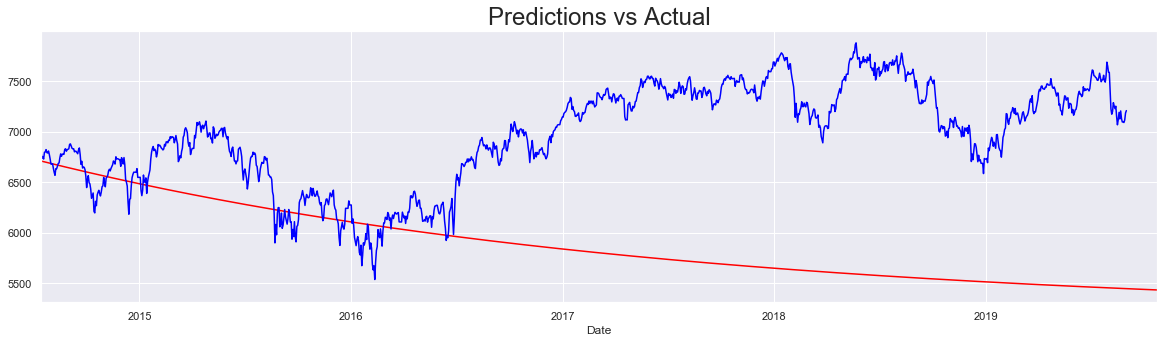

In [28]:
df_pred[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

The prediction shows that AR model does not perform well on predicting non-stationary data!

## AR model to predict Returns

#### Order 1 AR model for return

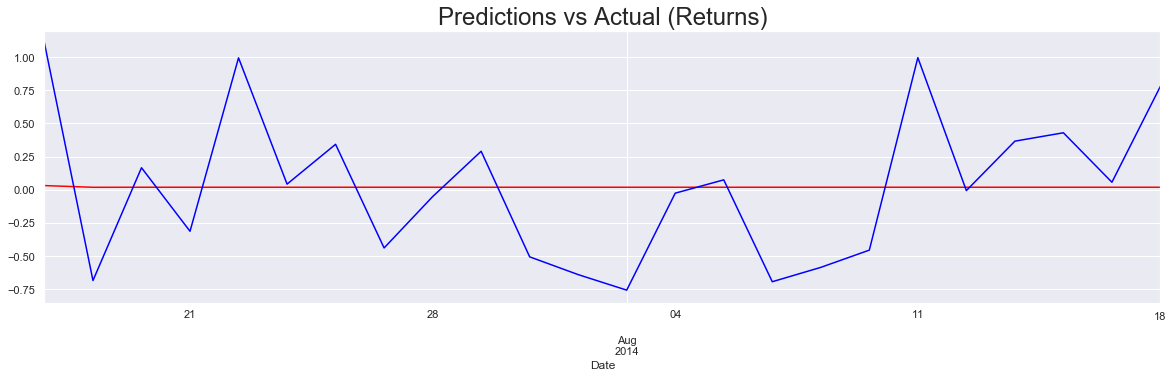

In [31]:
end_date = "2014-08-18"

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (1,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

The forecasting is 0, indicating no prediction power. Coefficiets for the past values and the values themselves have very low absolute values.

In [33]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(1, 0)   Log Likelihood               -8344.717
Method:                       css-mle   S.D. of innovations              1.151
Date:                Wed, 15 Jul 2020   AIC                          16695.434
Time:                        13:47:32   BIC                          16715.189
Sample:                    01-11-1994   HQIC                         16702.334
                         - 07-15-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0191      0.015      1.243      0.214      -0.011       0.049
ar.L1.ret_ftse    -0.0231      0.014     -1.692      0.091      -0.050       0.004
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -43.2414           +0.0000j           43.2414            0.5000
-----------------------------------------------------------------------------
"""

The summary shows that const and coefficient values are small. And constant is not significant(p=0.214)

#### Order 5 AR model for return


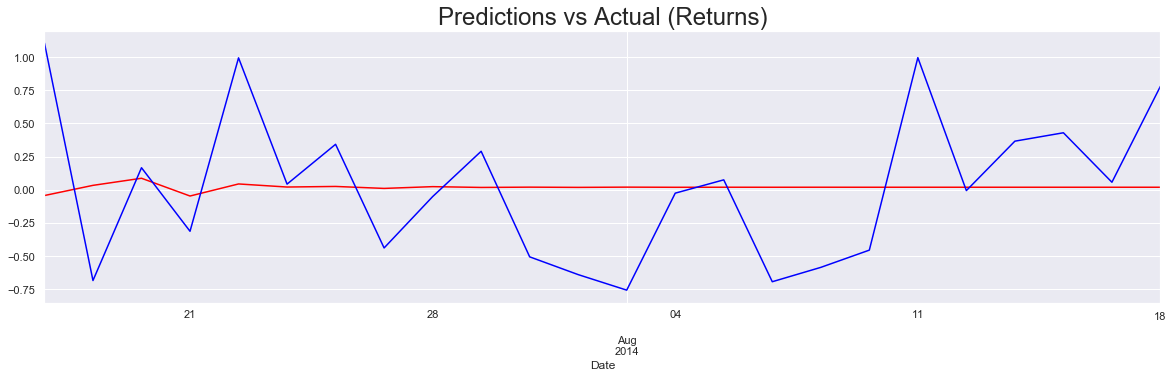

In [34]:
end_date = "2014-08-18"

model_ret_ar = ARIMA(df.ret_ftse[1:], order = (5,0,0))
results_ret_ar = model_ret_ar.fit()

df_pred_ar = results_ret_ar.predict(start = start_date, end = end_date) 

df_pred_ar[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [36]:
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(5, 0)   Log Likelihood               -8307.926
Method:                       css-mle   S.D. of innovations              1.143
Date:                Wed, 15 Jul 2020   AIC                          16629.851
Time:                        13:48:58   BIC                          16675.947
Sample:                    01-11-1994   HQIC                         16645.952
                         - 07-15-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0192      0.013      1.435      0.151      -0.007       0.045
ar.L1.ret_ftse    -0.0222      0.014     -1.630      0.103      -0.049       0.005
ar.L2.ret_ftse    -0.0531      0.014     -3.891      0.000      -0.080      -0.026
ar.L3.ret_ftse    -0.0807      0.014     -5.925      0.000      -0.107      -0.054
ar.L4.ret_ftse     0.0422      0.014      3.095      0.002       0.015       0.069
ar.L5.ret_ftse    -0.0561      0.014     -4.114      0.000      -0.083      -0.029
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.5671           -0.0000j            1.5671           -0.5000
AR.2           -0.2911           -1.7478j            1.7719           -0.2763
AR.3           -0.2911           +1.7478j            1.7719            0.2763
AR.4            1.4506           -1.2313j            1.9027           -0.1120
AR.5            1.4506           +1.2313j            1.9027            0.1120
-----------------------------------------------------------------------------
"""

Very small shift among the initial forecasts. But the curve flattens quickly since forecasted values getting smaller and smaller. Every single period where the values shift they are moving the opsite direction.

**Increasing the order makes litter difference in forcasting capabilities of the model**

## MA Model
### Simple MA Model

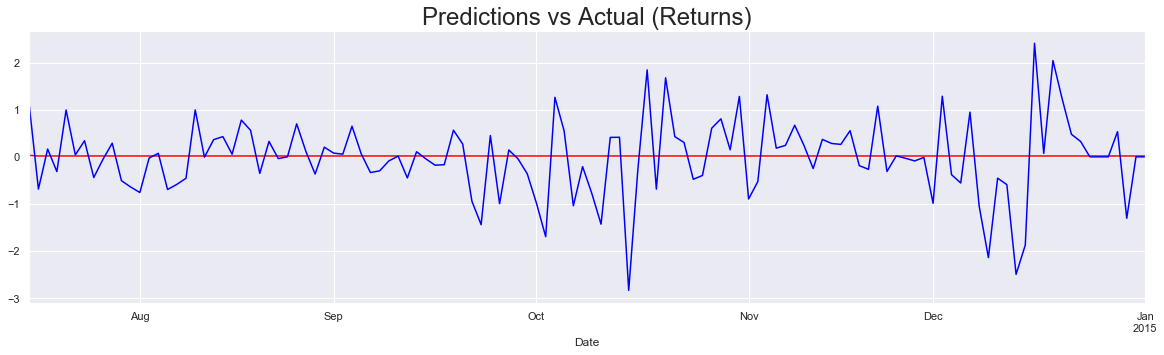

In [37]:
end_date = "2015-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,1))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [38]:
df_pred_ma.head()

2014-07-16    0.032676
2014-07-17    0.019121
2014-07-18    0.019121
2014-07-21    0.019121
2014-07-22    0.019121
Freq: B, dtype: float64

forecasted values after first period didn't change. 

In [40]:
results_ret_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(0, 1)   Log Likelihood               -8344.556
Method:                       css-mle   S.D. of innovations              1.151
Date:                Wed, 15 Jul 2020   AIC                          16695.111
Time:                        13:57:08   BIC                          16714.866
Sample:                    01-11-1994   HQIC                         16702.011
                         - 07-15-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0191      0.015      1.248      0.212      -0.011       0.049
ma.L1.ret_ftse    -0.0258      0.014     -1.782      0.075      -0.054       0.003
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           38.7776           +0.0000j           38.7776            0.0000
-----------------------------------------------------------------------------
"""

const = 0.0191. After the first period, there is no error terms, which leads to the prediction no changing.

### Higher Order of MA

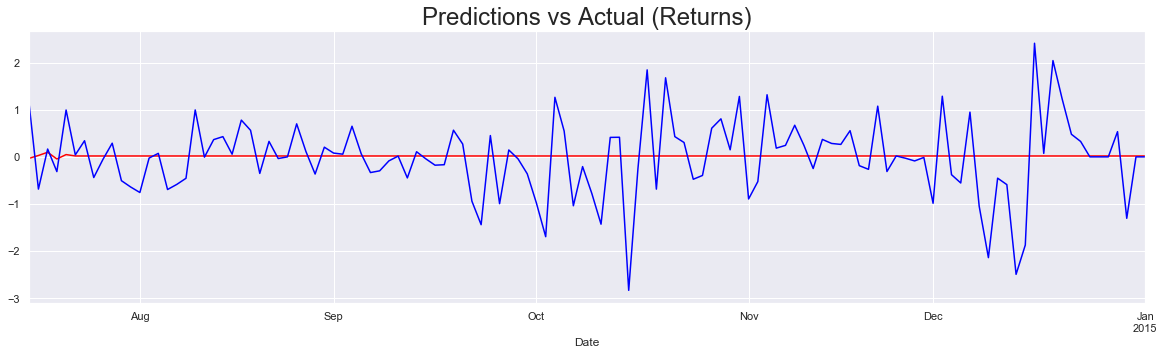

In [41]:
end_date = "2015-01-01"

model_ret_ma = ARIMA(df.ret_ftse[1:], order=(0,0,5))
results_ret_ma = model_ret_ma.fit()

df_pred_ma = results_ret_ma.predict(start = start_date, end = end_date) 

df_pred_ma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [42]:
results_ret_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               ret_ftse   No. Observations:                 5351
Model:                     ARMA(0, 5)   Log Likelihood               -8308.223
Method:                       css-mle   S.D. of innovations              1.143
Date:                Wed, 15 Jul 2020   AIC                          16630.446
Time:                        13:59:30   BIC                          16676.542
Sample:                    01-11-1994   HQIC                         16646.547
                         - 07-15-2014                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0192      0.013      1.460      0.144      -0.007       0.045
ma.L1.ret_ftse    -0.0261      0.014     -1.901      0.057      -0.053       0.001
ma.L2.ret_ftse    -0.0486      0.014     -3.551      0.000      -0.075      -0.022
ma.L3.ret_ftse    -0.0825      0.014     -5.819      0.000      -0.110      -0.055
ma.L4.ret_ftse     0.0441      0.013      3.343      0.001       0.018       0.070
ma.L5.ret_ftse    -0.0471      0.014     -3.363      0.001      -0.075      -0.020
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.2258           -1.0931j            1.6424           -0.3841
MA.2           -1.2258           +1.0931j            1.6424            0.3841
MA.3            1.7518           -0.0000j            1.7518           -0.0000
MA.4            0.8179           -1.9555j            2.1197           -0.1870
MA.5            0.8179           +1.9555j            2.1197            0.1870
-----------------------------------------------------------------------------
"""

## ARMA Model
### Simple ARMA model

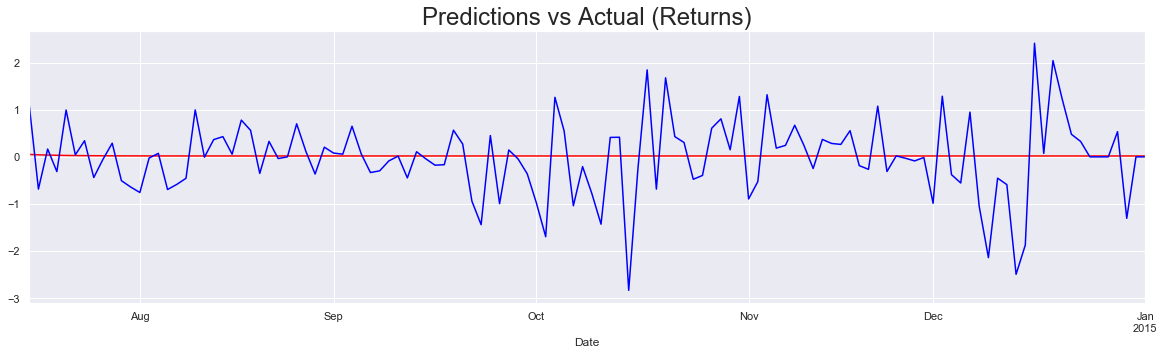

In [43]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(1,0,1))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [44]:
df_pred_arma.head()

2014-07-16    0.051209
2014-07-17    0.043852
2014-07-18    0.038184
2014-07-21    0.033818
2014-07-22    0.030455
Freq: B, dtype: float64

In [45]:
df_pred_arma.tail()

2014-12-26    0.019172
2014-12-29    0.019172
2014-12-30    0.019172
2014-12-31    0.019172
2015-01-01    0.019172
Freq: B, dtype: float64

ARMA provides slightly more reasonable predictions as predictions do not die off immedidately.

### Higher order of ARMA model

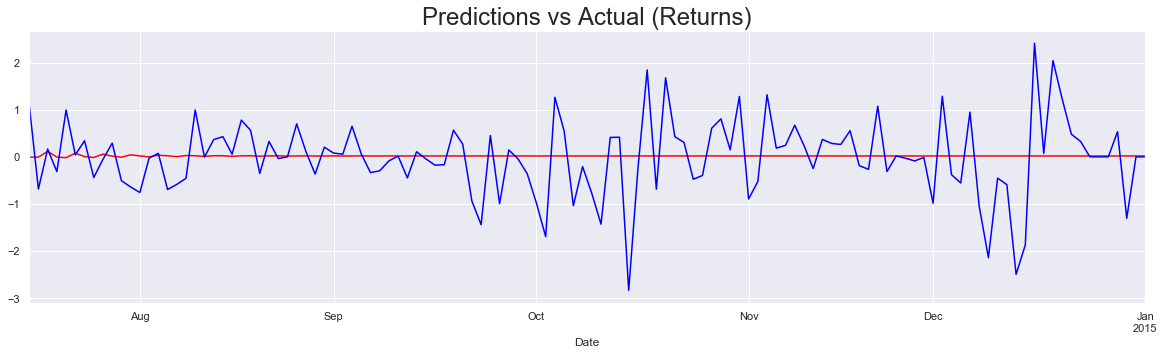

In [46]:
model_ret_arma = ARIMA(df.ret_ftse[1:], order=(3,0,3))
results_ret_arma = model_ret_arma.fit()

df_pred_arma = results_ret_arma.predict(start = start_date, end = end_date)

df_pred_arma[start_date:end_date].plot(figsize = (20,5), color = "red")   
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

In [47]:
df_pred_arma.head(10)

2014-07-16   -0.006579
2014-07-17   -0.005218
2014-07-18    0.117217
2014-07-21   -0.005304
2014-07-22   -0.016909
2014-07-23    0.079852
2014-07-24    0.006338
2014-07-25   -0.013481
2014-07-28    0.058106
2014-07-29    0.015149
Freq: B, dtype: float64

In [48]:
df_pred_arma.tail(10)

2014-12-19    0.01917
2014-12-22    0.01917
2014-12-23    0.01917
2014-12-24    0.01917
2014-12-25    0.01917
2014-12-26    0.01917
2014-12-29    0.01917
2014-12-30    0.01917
2014-12-31    0.01917
2015-01-01    0.01917
Freq: B, dtype: float64

## ARmAX Model
Non integrated ARIMAX model, includes an exogenous variable

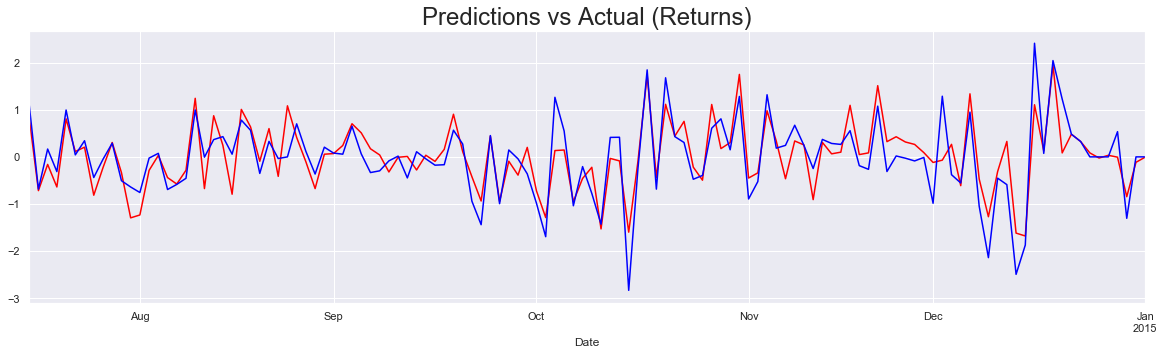

In [49]:
model_ret_armax = ARIMA(
                    df.ret_ftse[1:],
                    exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:],
                    order = (1,0,1))

results_ret_armax = model_ret_armax.fit()

df_pred_armax = results_ret_armax.predict(
    start = start_date, end = end_date, 
    exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 
# exogenous variables in prediction should be from test set df_test
# No need to avoid the first item in test set, because it is not null
df_pred_armax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (Returns)", size = 24)
plt.show()

Overall, the forecasting follows the data well. **including outside factors improved the predictive power dramstically** Problem is when to forecast data into the future, MAX model may lack of the infomation of Exogenous variables.

## SARMA

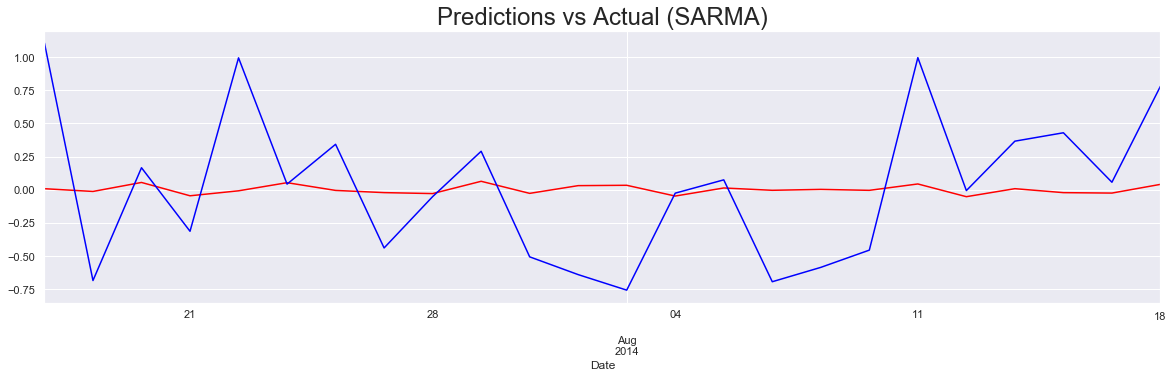

In [50]:
end_date = "2014-08-18"
model_ret_sarma = SARIMAX(
                    df.ret_ftse[1:], 
                    order = (3,0,4), 
                    seasonal_order = (3,0,2,5))
results_ret_sarma = model_ret_sarma.fit()

df_pred_sarma = results_ret_sarma.predict(start = start_date, end = end_date)

df_pred_sarma[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual (SARMA)", size = 24)
plt.show()

Most predictions are close to 0. However, the predictions are wigly instead of constantly decreasing. 

In [51]:
df_pred_sarma.head(10)

2014-07-16    0.008148
2014-07-17   -0.012564
2014-07-18    0.055212
2014-07-21   -0.045229
2014-07-22   -0.007766
2014-07-23    0.053515
2014-07-24   -0.004768
2014-07-25   -0.021318
2014-07-28   -0.028608
2014-07-29    0.064007
Freq: B, dtype: float64

### SARIMAX model

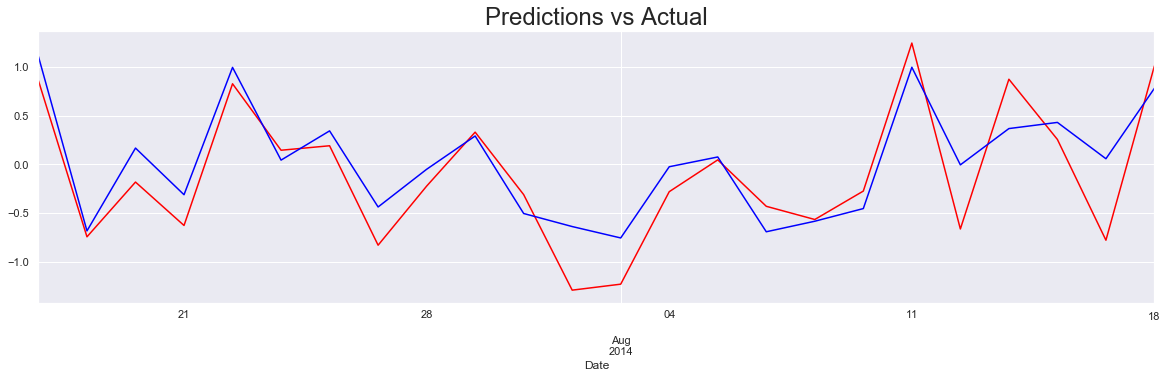

In [52]:

model_ret_sarimax = SARIMAX(
                        df.ret_ftse[1:], 
                        exog = df[["ret_spx","ret_dax","ret_nikkei"]][1:],
                        order = (3,0,4), 
                        seasonal_order = (3,0,2,5))
results_ret_sarimax = model_ret_sarimax.fit()

df_pred_sarimax = results_ret_sarimax.predict(
    start = start_date, 
    end = end_date, 
    exog = df_test[["ret_spx","ret_dax","ret_nikkei"]][start_date:end_date]) 

df_pred_sarimax[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.show()

The predictions follows the data closely.

## USE Auto arima for model selection

In [54]:
# from pmdarima.arima import auto_arima
# from arch import arch_model
model_auto = auto_arima(
                df.ret_ftse[1:], 
                exogenous = df[['ret_spx', 'ret_dax', 'ret_nikkei']][1:],
                m = 5, 
                max_p = 5, 
                max_q = 5, 
                max_P = 5, 
                max_Q = 5)

In [62]:
# model_auto.predict() doesn't return a dataframe, but an NP array
df_auto_pred = pd.DataFrame(
    model_auto.predict(n_periods = len(df_test[start_date:end_date]),
    exogenous = df_test[['ret_spx', 'ret_dax', 'ret_nikkei']][start_date:end_date]),
    index = df_test[start_date:end_date].index)

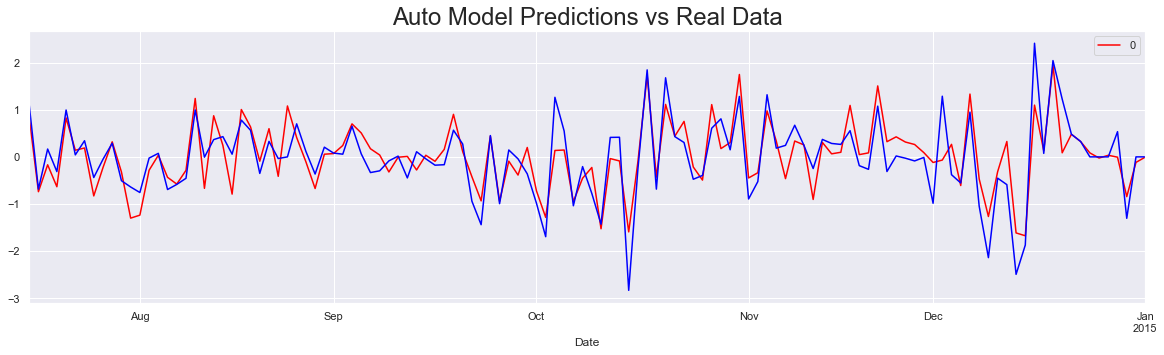

In [63]:
df_auto_pred.plot(figsize = (20,5), color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.title("Auto Model Predictions vs Real Data", size = 24)
plt.show()

Compare All Models on Returns

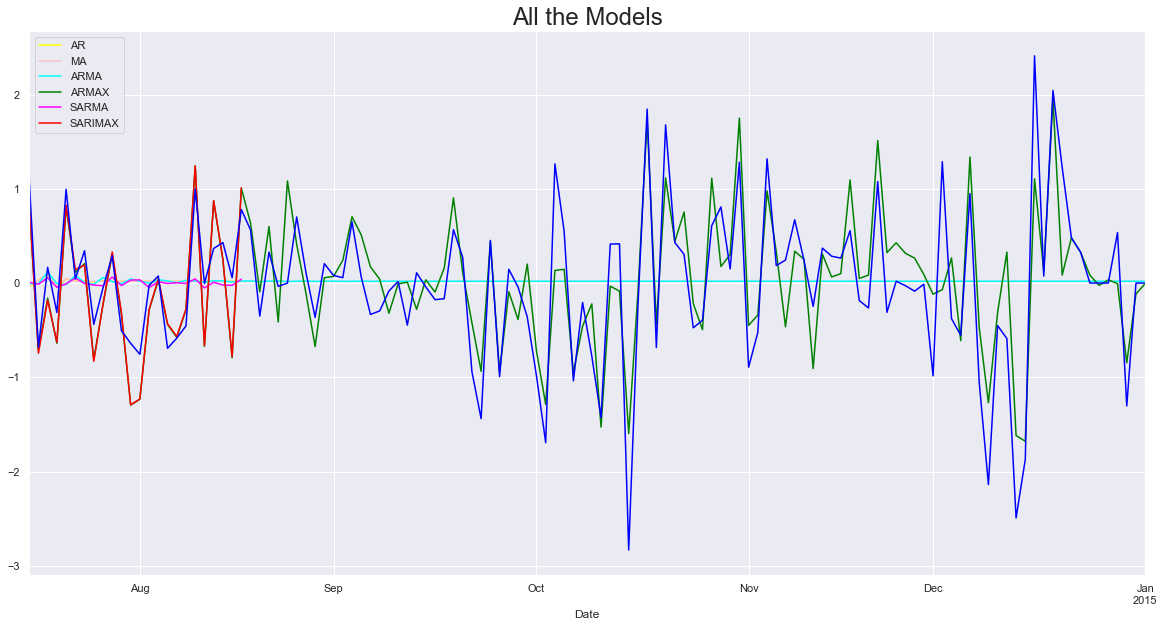

In [64]:
end_date = "2015-01-01"
df_pred_ar[start_date:end_date].plot(figsize = (20,10), color = "yellow")
df_pred_ma[start_date:end_date].plot(color = "pink")
df_pred_arma[start_date:end_date].plot(color = "cyan")
df_pred_armax[start_date:end_date].plot(color = "green")
df_pred_sarma[start_date:end_date].plot(color = "magenta")
df_pred_sarimax[start_date:end_date].plot(color = "red")
df_test.ret_ftse[start_date:end_date].plot(color = "blue")
plt.legend(['AR','MA','ARMA','ARMAX','SARMA','SARIMAX'])
plt.title("All the Models", size = 24)
plt.show()

## Forecasting Volatility with ARCH

In [65]:
mod_garch = arch_model(
                df_comp.ret_ftse[1:], 
                vol = "GARCH", 
                p = 1, 
                q = 1, 
                mean = "constant", 
                dist = "Normal")
                
res_garch = mod_garch.fit(last_obs = start_date, update_freq = 10)

Iteration:     10,   Func. Count:     74,   Neg. LLF: 7311.064967581857
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 7311.064229906402
            Iterations: 12
            Function evaluations: 86
            Gradient evaluations: 12


In [66]:
pred_garch = res_garch.forecast(
    horizon = 1, # How many observations we want our model to predict for each date; for each date, we will get the predicted value for next date
    align = 'target' # determine whethere we watch the value with the date prediction is made on, or the one it's supposed to represent
    )

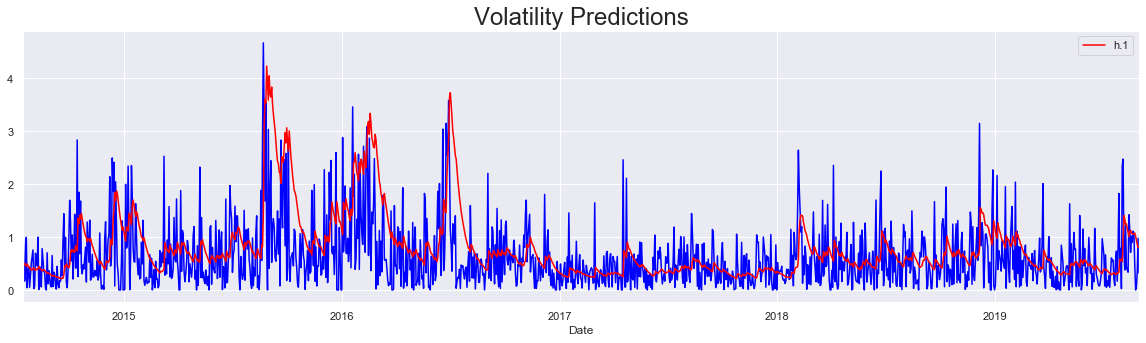

In [67]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_ftse.abs().plot(color = "blue", zorder = 1)
plt.title("Volatility Predictions", size = 24)
plt.show()

In [68]:
pred_garch = res_garch.forecast(horizon = 100, align = 'target')
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,0.811449,0.805648,0.867232,0.940608,1.02073,1.084989,1.074064,1.067783,1.08121,1.090608,...,0.83728,0.838888,0.830292,0.815455,0.827095,0.839331,0.850645,0.864163,0.871725,0.886197


## Multvariate Regression Model

In [69]:
from statsmodels.tsa.api import VAR
df_ret = df[['ret_spx', 'ret_dax', 'ret_ftse', 'ret_nikkei']][1:]
model_var_ret = VAR(df_ret)
model_var_ret.select_order(20)
results_var_ret = model_var_ret.fit(ic = 'aic')
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 15, Jul, 2020
Time:                     14:45:06
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                   0.330716
Nobs:                     5346.00    HQIC:                  0.263399
Log likelihood:          -30866.1    FPE:                    1.25516
AIC:                     0.227263    Det(Omega_mle):         1.23563
--------------------------------------------------------------------
Results for equation ret_spx
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.039150         0.016160            2.423           0.015
L1.ret_spx           -0.110568         0.017558           -6.297           0.000
L1.ret_dax            0.065289         0.019034           

Having multiple endogenous variables drastically increases the order. 

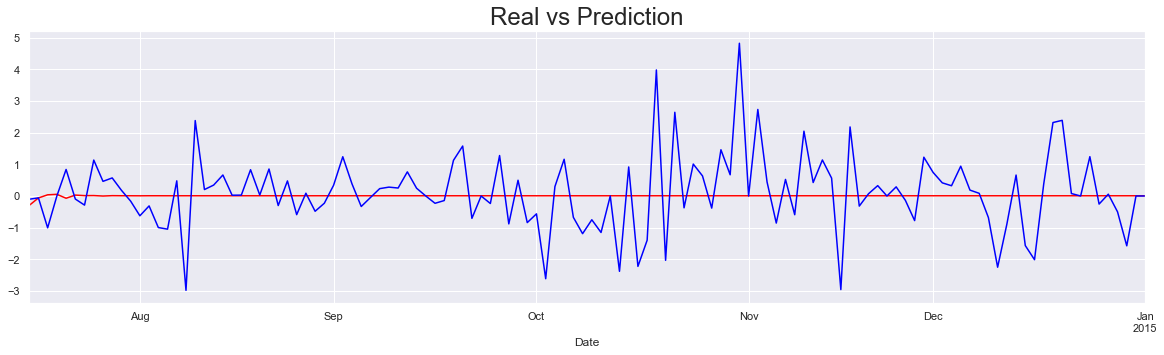

In [70]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(
    df_ret.values[-lag_order_ret:], # transform the dataframe into NP array
    # lag_order_retlag_order_ret: use the last # elements to make first prediction# use the last # elements to make first prediction
    len(df_test[start_date:end_date]) # how long for predictions
    ) 

df_ret_pred = pd.DataFrame(
    data = var_pred_ret, 
    index = df_test[start_date:end_date].index,
    columns = df_test[start_date:end_date].columns[4:8]
    )

df_ret_pred.ret_nikkei[start_date:end_date].plot(figsize = (20,5), color = "red")

df_test.ret_nikkei[start_date:end_date].plot(color = "blue")
plt.title("Real vs Prediction", size = 24)
plt.show()

Predictions flattens.  Model past values for these additional time series, but not the extremely valuable input of today's values into the mix. This is why the model performs just like an expanded A.R. model.

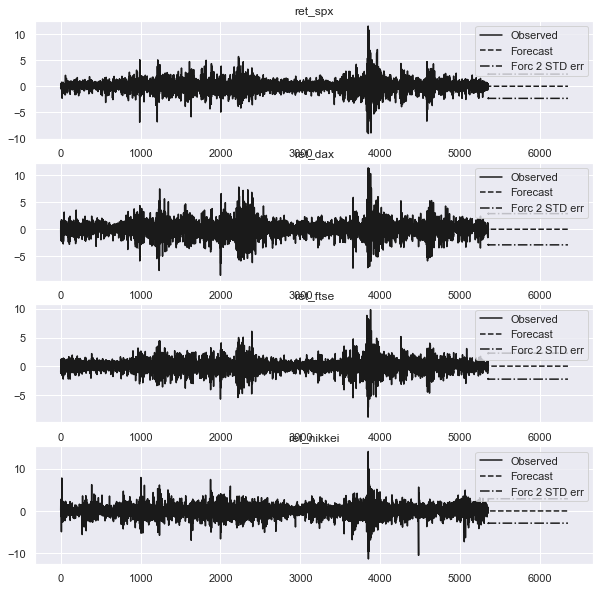

In [71]:
results_var_ret.plot_forecast(1000)
plt.show()

long term stability in the market assuming no unpredictable